###                         Comment remplir les valeurs manquantes de consommation électrique des clients ?

Challenge réalisé par Yann PALUCH et Alexis BRUNIERA.

# __1. Compréhension et analyse des données__

### **1.1 Données du Challenge**

$But$

Le challenge que nous proposons consiste à reconstruire les données manquantes de certaines courbes de consommation électrique en utilisant uniquement d’autres courbes de consommation électrique.
Nous avons utilisé un outil de génération de courbes synthétiques, DeepCourbogen, pour générer environ 69 000 courbes. 1 000 de ces courbes ont subi des suppressions aléatoires de données, pour simuler les données manquantes de courbes réelles.

Le but des challengers est de proposer des remplacements pour les données manquantes (« remplir les trous ») dans les 1 000 courbes.
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

$Description des données$

Pour l’échantillon d’entrainement :

- la donnée d’entrée est une dataframe de 21 000 colonnes. Chacune d’entre elles est une courbe synthétique générée par DeepCourbogen. Chaque nom de colonne est un identifiant () généré aléatoirement. L’index de la dataframe est le timestamp de chaque point, les valeurs de consommation sont en watts. Les 1 000 dernières colonnes contiennent les courbes auquelles il manque des données. Les noms de ces colonnes sont de la forme holed_
- La donnée de sortie est une dataframe de 1 000 colonnes contenant les données complétées des 1 000 dernières colonnes des données d’entrée.
Le fichier d’entrée fait 140 Mo, le fichier de sortie 6 Mo.

Pour l’échantillon de test, la donnée d’entrée est une dataframe de 38140 colonnes (260 Mo), la donnée de sortie fait toujours 1000 colonnes (6 Mo)
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

### **1.2 Extraction des données**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Échantillon d'entraînement
df_X_train = pd.read_csv('X_train_78VdSWL.csv') # Donnée d’entrée, dataframe de 21 000 (140 Mo)
Y_train = pd.read_csv('y_train_u0UkKEh.csv') # Donnée de sortie, 1000 colonnes manquantes (6 Mo)

# Échantillon de test
df_X_test = pd.read_csv('X_test_XKVc4no.csv') # Donnée d’entrée, dataframe de 38140 colonnes (260 Mo)
#Y_test = pd.read_csv('new_output_sample.csv')

### **1.3 Modélisation d'une courbe**

Pour mieux ce représenter les données, essayons de modéliser une courbe.

In [2]:
df_X_train.columns

Index(['Horodate', '5423908671', '2568793410', '8310762594', '6235194807',
       '423895617', '193845276', '216589743', '218753964', '1794650328',
       ...
       'holed_991', 'holed_992', 'holed_993', 'holed_994', 'holed_995',
       'holed_996', 'holed_997', 'holed_998', 'holed_999', 'holed_1000'],
      dtype='object', length=21001)

On affiche à l'écran le nom de chaque colonne du DataFrame des données d'entrainement pour pouvoir sélectionner celle que l'on souhaite.

On sélectionne la colonne 'holed_1000' car d'après l'énoncé, c'est une courbe avec des données manquantes.

In [3]:
df_X_test['holed_1000']

0       129.0
1       113.0
2         NaN
3       135.0
4         NaN
        ...  
1052      NaN
1053     78.0
1054     57.0
1055     49.0
1056     42.0
Name: holed_1000, Length: 1057, dtype: float64

On observe bien qu'il y a des valeurs manquante (NaN = une valeur manquante).

Affichons la courbe de données de la colonne holed_1000.

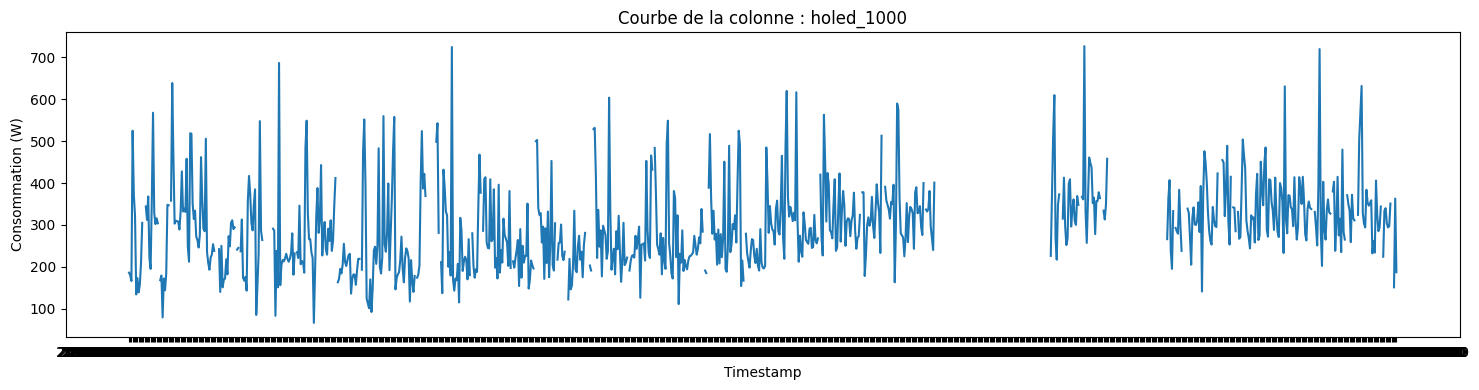

In [4]:
X = df_X_train['Horodate']
Y_holed1000 = df_X_train['holed_1000']
plt.figure(figsize=(15, 4))
plt.plot(X, Y_holed1000)
plt.title("Courbe de la colonne : holed_1000")
plt.xlabel('Timestamp')
plt.ylabel('Consommation (W)')
plt.tight_layout()
plt.show()


#Problème d'affichage des abscisses...

On observe bien sur la courbe qu'il y a des espaces vides.

Notre but sera de faire des estimations avec le moins d'erreur possibles pour essayer de remplir ses epaces.

### **1.4 MAE**
Pour calculer notre erreur nous allons faire une fonction MAE (Erreur Absolue Moyenne) que nous utiliserons dès que nous voudrons évaluer nos estimations. La MAE est la moyenne des erreurs absolues ramenée au nombre réel de valeurs manquantes.

In [5]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def MAE(Y_reel, Y_pred):
    a = np.asarray(Y_reel)
    b = np.asarray(Y_pred)
    mask = ~np.isnan(a) & ~np.isnan(b)

    return mean_absolute_error(a[mask], b[mask])

### **1.5 Modélisation du Benchmark**

Dans l'énoncé du Challenge, on nous donne comme exemple un "Benchmark" basique consistant à faire de l’interpolation linéaire sur les données manquantes. On a la fonction suivante :

In [6]:
def fill_nan_with_interpolation(column):
    col = column.copy()
    col = col.interpolate(method='linear', limit_direction='both')
    return col

Essayer de l'utiliser pour modéliser le Benchmark.

In [7]:
Y_reel_holed1000 = Y_train['holed_1000']

def modélisation(Y_pred_holed1000):
    plt.figure(figsize=(15, 4))
    plt.plot(X, Y_pred_holed1000, 'r--', label="holed_1000 (compléter)")
    plt.plot(X, Y_reel_holed1000, 'g', label="holed_1000 (réel)")
    plt.plot(X, Y_holed1000, label="holed_1000 (avec NaN)")
    plt.title("Courbe de la colonne : holed_1000")
    plt.xlabel('Timestamp')
    plt.ylabel('Consommation (W)')
    plt.legend()
    plt.tight_layout()
    plt.show()

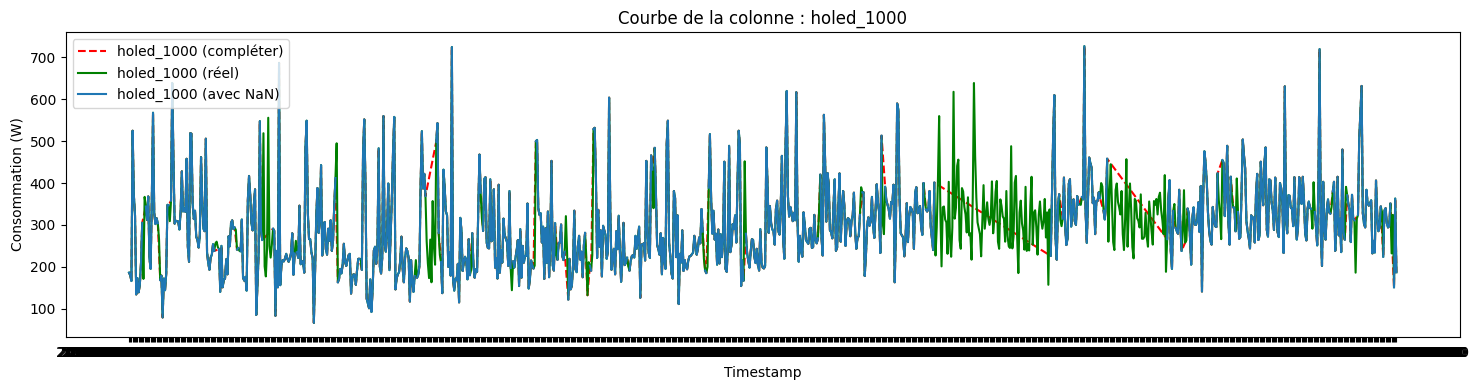

In [8]:
Y_pred_holed1000 = fill_nan_with_interpolation(Y_holed1000)
modélisation(Y_pred_holed1000)

In [9]:
mae = MAE(Y_reel_holed1000,Y_pred_holed1000)
print(f"MAE du modèle : {mae:.4f}")

MAE du modèle : 15.1421


On obtient le résultat mais pour une courbe, il faudrait essayer de le faire pour toute les courbes qui ont des données manquantes.

### **1.6 Benchmark sur les données d'entraînement**

On doit sélectionner les colonnes d'indice 20 001 à 21 000 pour avoir les 1000 dernières colonnes qui ont des données manquantes.

Cependant attention au cas de figure ou les données réels sont totalement vide :

In [10]:
Y_train['holed_192']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1052   NaN
1053   NaN
1054   NaN
1055   NaN
1056   NaN
Name: holed_192, Length: 1057, dtype: float64

Comme on peut le constater, la colonne 'holed_192' est vide (du moins quasiment car en observant dans un tableur, il y a un exception à la ligne 201, on a la valeur 0.0).

Nous devons donc prendre en compte ce cas de figure.

In [11]:
def evaluer_interpolation(df_X, df_Y, interpolation_func, method_name):
    j = 0
    Liste_mae_train = []
    
    for i in range(20001, 21001):   
        Y_origin = df_X.iloc[:, i]
        Y_pred = interpolation_func(Y_origin)
        Y_reel = df_Y.iloc[:, j+1]
        Liste_mae_train.append(MAE(Y_reel, Y_pred))
        j += 1

    moyenne_mae_train = np.mean(Liste_mae_train)
    print(f"Moyenne des MAE des données de l'échantillon d'entraînement (Interpolation {method_name}) : {moyenne_mae_train:.4f}")

In [12]:
evaluer_interpolation(df_X_train, Y_train, fill_nan_with_interpolation, "Linéaire")

Moyenne des MAE des données de l'échantillon d'entraînement (Interpolation Linéaire) : 12.4283


### **1.7 Création du fichier Y_test.csv**

Maintenant, pour pouvoir être évalué par le challenge, il nous faut un fichier Y_test.csv, nous allons donc le créer pour pouvoir avoir notre score et bien retrouvé le score de 104,5368 car nous utilisons le benchmark.

In [13]:
horodate = df_X_test[['Horodate']]
holed = []

for i in range(1, 1001):
    holed_X = f'holed_{i}'
    Y_filled = fill_nan_with_interpolation(df_X_test[holed_X]).round(1)
    holed.append(Y_filled.rename(holed_X))
Y_test = pd.concat([horodate] + holed, axis=1)

Y_test.to_csv("Y_test.csv", index=False)


Après envoie de "Y_test.csv", nous obtenons bien un score de 104,5368.

Maintenant que toute les données sont claires, nous pouvons passéer à l'étape suivante et essayer de faire baisser le plus possible la MAE.


# __2. Test de nouvelles estimations__

### __2.1 Estimation sur la moyenne des points en fonctions du temps__

On remarque en premier lieu qu'il y a des corélations entre les données, par exemple, à 17h, la consommation d'énergie chute. On peut donc commencer par faire des estimations par rapport à la moyenne des données en fonction de l'heure.

D'abord on sait qu'il y a 1057 lignes, avec un rapides calcul en fonction des données observer on peu déduire qu'il y 48 crénaux horaires différents étaler sur 22 jours (+ 1 lignes pour le 31 à minuit)

In [14]:
print(48*22+1)

1057


Ainsi, comme les valeurs de X sont périodiques, nous retrouvons les même horaire toute les 48 lignes (seulement ce n'est pas le même jours). Nous aurons donc 48 points à calculer sur les 20 000 premières colonnes de X_train.

Pour commencer, réalisons le calcul sur de ces données sur une colonne.

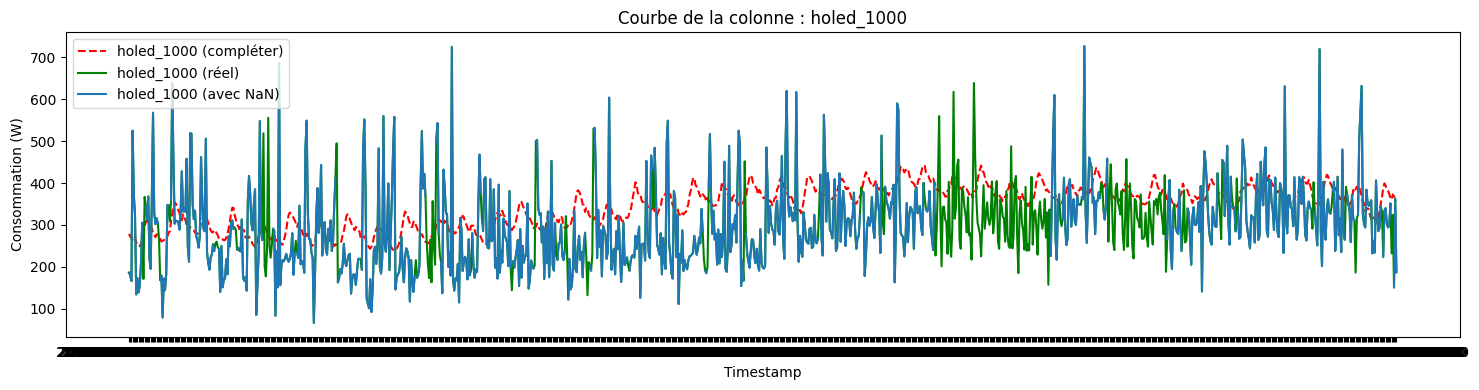

In [15]:
train_values = df_X_train.iloc[:, 1:20001]
Y_pred_holed1000 = train_values.mean(axis=1).round(1)

modélisation(Y_pred_holed1000)

In [16]:
mae = MAE(Y_reel_holed1000,Y_pred_holed1000)
print(f"MAE du modèle : {mae:.4f}")

MAE du modèle : 88.0648


On remarque que la MAE n'est vraiment pas bonne, et les données compléter non aucun corrélations avec les données réel. Il faut que l'on change de méthode.

### __2.2 Retour sur l'interpolation__

En première partie on a longtemps étudié l'interpolation linéaire, cependant si elle est linéaire, elle peut être aussi sous d'autres formes et après quelques recherches rapides on trouve qu'il existe effectivement d'autres méthodes d'interpolation, nous allons en tester quelques-unes qui sont pertinantes.

In [17]:
def interpolation_spline(column):
    col = column.copy()
    col = col.interpolate(method='spline', order=3, limit_direction='both')

    return col

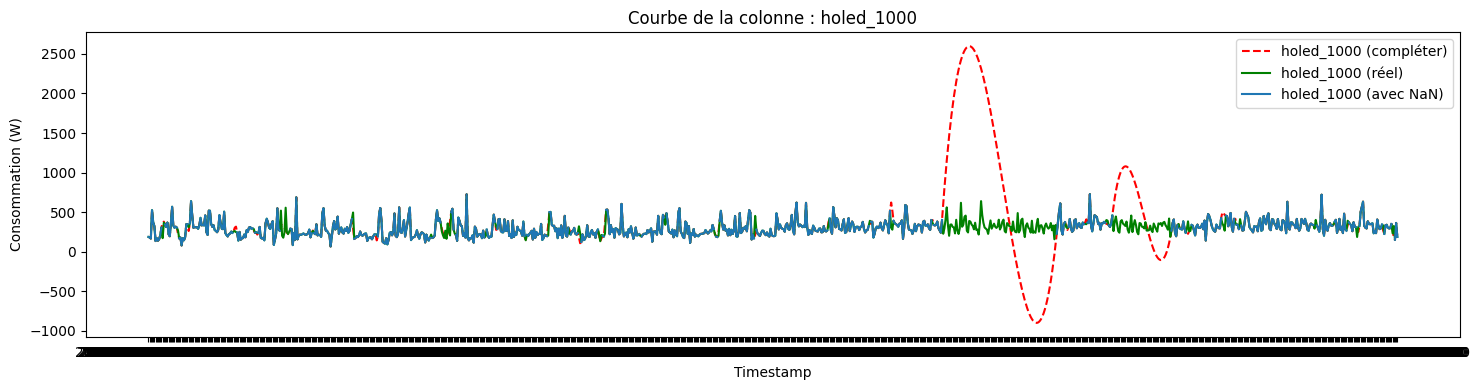

In [18]:
Y_pred_holed1000 = interpolation_spline(Y_holed1000)
modélisation(Y_pred_holed1000)

Le problème de cette fonction semble assez évident... pour des trop gros espace la fonction effectue de trop grands écart, elle ne nous intéressera pas.

In [19]:
def interpolation_nearest(column):
    col = column.copy()
    col = col.interpolate(method='nearest', limit_direction='both')
    col = col.bfill().ffill() #certaines colonnes était vides au début ou à la fin, donc ont les remplies avec le première ou la dernière valeurs connues.
    # Beginfill ou FinishFill
    return col

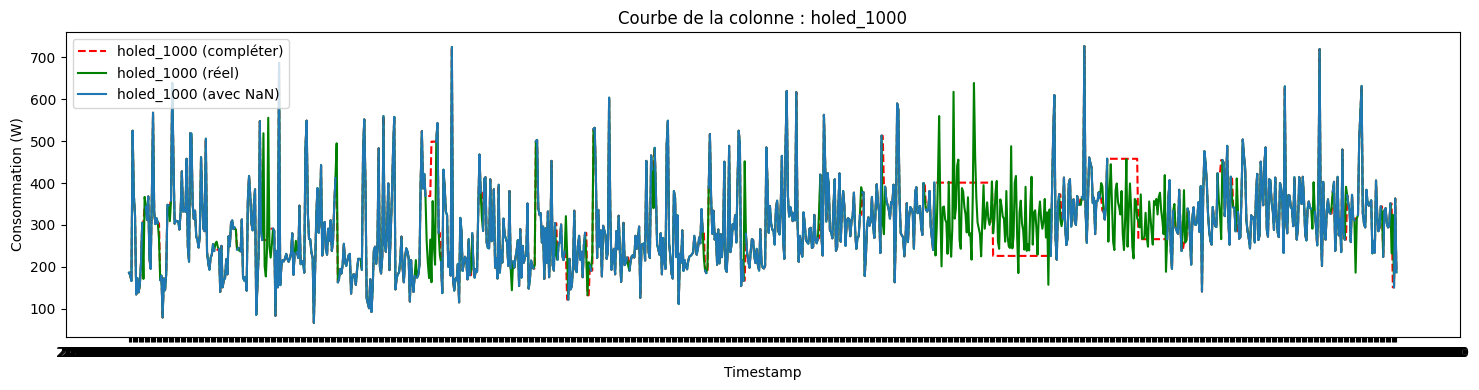

In [20]:
Y_pred_holed1000 = interpolation_nearest(Y_holed1000)
modélisation(Y_pred_holed1000)

Celle-ci a du potentiel, on peut tenter de l'étudier.

In [21]:
evaluer_interpolation(df_X_train, Y_train, interpolation_nearest, "Nearest")

Moyenne des MAE des données de l'échantillon d'entraînement (Interpolation Nearest) : 13.6411


Et effectivement, la MAE est plus petite que l'interpolation linéaire, tentons de voir quel va être le score du challenge en utilisant cette fonction.

In [22]:
horodate = df_X_test[['Horodate']]
holed = []

for i in range(1, 1001):
    holed_X = f'holed_{i}'
    Y_filled = interpolation_nearest(df_X_test[holed_X])
    holed.append(Y_filled.rename(holed_X))
Y_test = pd.concat([horodate] + holed, axis=1)

Y_test.to_csv("Y_test (Interpolation Nearest).csv", index=False)

Malheuresement le score du challenge est de 114,1553 nous devons tester autre chose.

### __2.3 ...__